# CanESM-GEM coupler budget check

This notebook computes global integrals of fields on the atmosphere and ocean side of the coupler remapping.

In the atmosphere, global integrals are computed on the Yin Yang grids, and compared to the integral of the equivalent
field on the NEMO grid.

Different runs with different remapping options are tested, primarily:
- goddard weighted, but uncorrected
- goddard weighted, corrected (blended)
- no weighting, pure blending


In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import fstd2nc
import cftime
import sys
import os
machine_epsilon = sys.float_info.epsilon

In [5]:
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=4, # The number of cores you want
    memory='128 GB', # Amount of memory
    processes=40, # How many processes
    queue='development', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=40:mem=128GB', # Specify resources
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(1)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)
client

/home/ncs001/.conda/envs/gem-vis/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 13915 instead
  warnings.warn(


<Client: 'tcp://10.102.15.227:12075' processes=0 threads=0, memory=0 B>

## Load coupler history files

In [6]:
root_dir="/home/ncs001/site5/gemdc-tests/cpl-remap-analy-2024-12"
#ds_cpl_his1 = xr.open_dataset(os.path.join(root_dir, 'mc_fix-crctns01_2003_cplhist.nc'), chunks={'time':250})  # Initial checks from early dev
#ds_cpl_his1 = xr.open_dataset(os.path.join(root_dir, 'mc_v6a3-3-cplhis-02_1950_m01_cplhist.nc.001'), chunks={'time':250})  # CanESM6-a3.3 TURNING OFF heat content correction. Expect as good a conservation as before.
ds_cpl_his1 = xr.open_dataset(os.path.join(root_dir, 'mc_v6a3-3-cplhis-01_1952_m01_cplhist.nc.001'), chunks={'time':100}) # # CanESM6-a3.3 with default on heat content correction. Expect poor conservation.


In [7]:
ds_cpl_his1

<xarray.Dataset>
Dimensions:                                                       (time: 2921,
                                                                   nlat_atm_yin: 115,
                                                                   nlon_atm_yin: 303,
                                                                   nlat_atm_yang: 115,
                                                                   nlon_atm_yang: 303,
                                                                   nlat_ocn: 332,
                                                                   nlon_ocn: 362)
Coordinates:
  * time                                                          (time) object ...
Dimensions without coordinates: nlat_atm_yin, nlon_atm_yin, nlat_atm_yang,
                                nlon_atm_yang, nlat_ocn, nlon_ocn
Data variables: (12/113)
    lon_atm_yin                                                   (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lat_atm_yin                                                   (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lon_atm_yang                                                  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lat_atm_yang                                                  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lon_ocn                                                       (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lat_ocn                                                       (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(332, 362), meta=np.ndarray>
    ...                                                            ...
    atm_yang2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_srcfrac  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    atm_yang2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_dstfrac  (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(332, 362), meta=np.ndarray>
    atm_yin2ocn_srcmaskF_dstmaskT_conservative_fracarea_srcfrac   (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    atm_yin2ocn_srcmaskF_dstmaskT_conservative_fracarea_dstfrac   (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(332, 362), meta=np.ndarray>
    atm_yang2ocn_srcmaskF_dstmaskT_conservative_fracarea_srcfrac  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    atm_yang2ocn_srcmaskF_dstmaskT_conservative_fracarea_dstfrac  (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(332, 362), meta=np.ndarray>
Attributes:
    CCCma_runid:  v6a3-3-cplhis-01

## Define computations

### For GEM / YY grids

In [8]:
# This is global atm area
ds = ds_cpl_his1
yy_area_integral = ((ds['god_weights_atm_yin'] * ds['cell_area_atm_yin']).sum() + 
                    (ds['god_weights_atm_yang'] * ds['cell_area_atm_yang']).sum()
                    )
def field_integral_yy(field_yin, field_yang):
    '''Goddard weighted global integral on the YG grids'''
    yin_weighted = (field_yin  * ds['god_weights_atm_yin']  * ds['cell_area_atm_yin'] 
                 * (1.0 - ds['flno_atm_yin']) ).compute() 

    yan_weighted =  (field_yang * ds['god_weights_atm_yang'] * ds['cell_area_atm_yang'] 
                 * (1.0 - ds['flno_atm_yang'])).compute()
    yin_integral = yin_weighted.sum(dim=['nlat_atm_yin' , 'nlon_atm_yin' ]).compute()
    yan_integral = yan_weighted.sum(dim=['nlat_atm_yang', 'nlon_atm_yang']).compute()
    
    return yin_integral + yan_integral

def field_average_yy(field_yin, field_yang):
    '''integral divided by global area'''
    integral = field_integral_yy(field_yin, field_yang)
    return integral/yy_area_integral 

### For NEMO / ORCA grid

In [9]:
nemo_area = ds.cell_area_ocn
nemo_area_integral = nemo_area.sum()

def field_integral_nemo(field):
    '''Global integral on the orca grid'''
    integral = (field * nemo_area).isel(nlon_ocn=slice(1,361)).isel(nlat_ocn=slice(0,292)).sum(dim=['nlat_ocn', 'nlon_ocn']) 
    return integral

def field_average_yy(field):
    '''integral divided by global area'''
    integral = field_integral_nemo(field)
    return integral/nemo_area_integral 

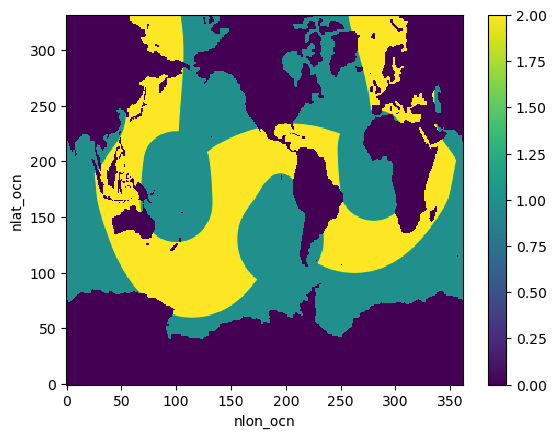

In [10]:
(ds_cpl_his1.atm_yin2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_dstfrac + 
ds_cpl_his1.atm_yang2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_dstfrac).plot()

In [11]:
dstfrac = (ds_cpl_his1.atm_yin2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_dstfrac + 
ds_cpl_his1.atm_yang2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_dstfrac)

dstfrac_ones = xr.where(dstfrac>1.99,1,dstfrac)
dstfrac_frac = xr.where((dstfrac<1) & (dstfrac>0), dstfrac, np.nan)

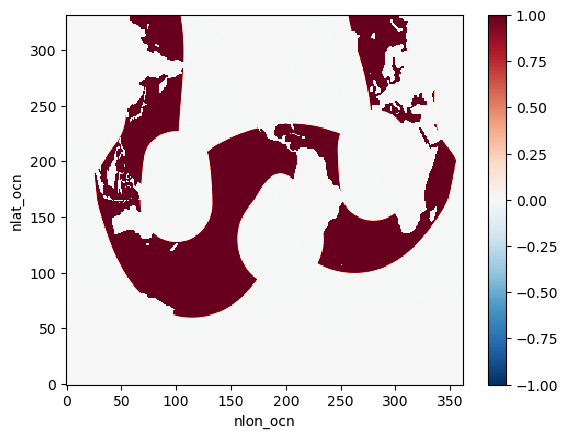

In [12]:
(dstfrac - ds_cpl_his1.nemo_tmask).plot()

In [13]:
(dstfrac - ds_cpl_his1.nemo_tmask).min().compute()

<xarray.DataArray ()>
array(-5.80646642e-14)

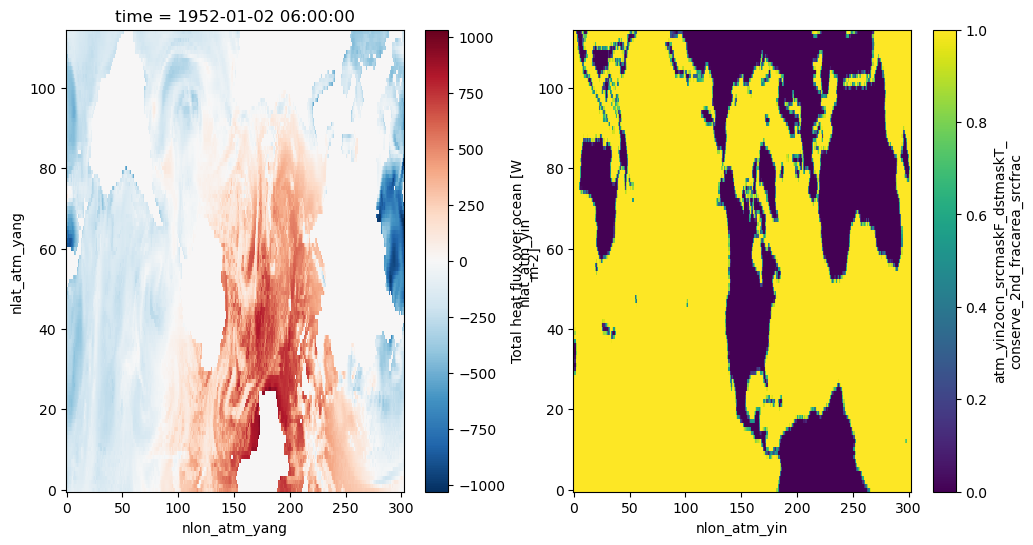

In [14]:
fig, (axl,axr) = plt.subplots(1,2, figsize=(12,6))

ds_cpl_his1.BEGO_atm_yang.isel(time=10).plot(ax=axl)
ds_cpl_his1.atm_yin2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_srcfrac.plot(ax=axr)

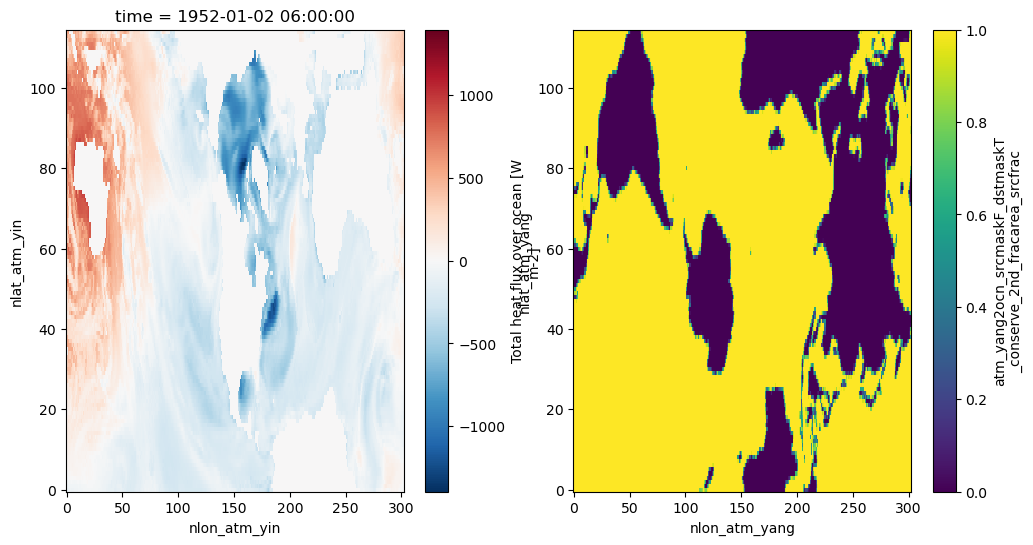

In [15]:
ds_frcfig, (axl,axr) = plt.subplots(1,2, figsize=(12,6))

ds_cpl_his1.BEGO_atm_yin.isel(time=10).plot(ax=axl)
ds_cpl_his1.atm_yang2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_srcfrac.plot(ax=axr)

## Basic budgets

## Timeseries of net heat flux integral

Given the way fields are divided, the net heat flux budget is:

    BWGI_atm + BWGO_atm = O_QnsMix + O_QsrMix
    

In [16]:
atm_net_heat = (field_integral_yy(ds_cpl_his1.BEGI_atm_yin  * ds_cpl_his1.SICN_atm_yin, 
                                  ds_cpl_his1.BEGI_atm_yang * ds_cpl_his1.SICN_atm_yang ).persist() + 
                field_integral_yy(ds_cpl_his1.BEGO_atm_yin  * (1.0- ds_cpl_his1.SICN_atm_yin), 
                                  ds_cpl_his1.BEGO_atm_yang * (1.0- ds_cpl_his1.SICN_atm_yang)).persist())
ocn_net_heat = (field_integral_nemo(ds_cpl_his1.O_QnsMix).persist() + 
               field_integral_nemo(ds_cpl_his1.O_QsrMix).persist())

<xarray.DataArray ()>
array(77.19993218) <xarray.DataArray ()>
array(0.05006038)


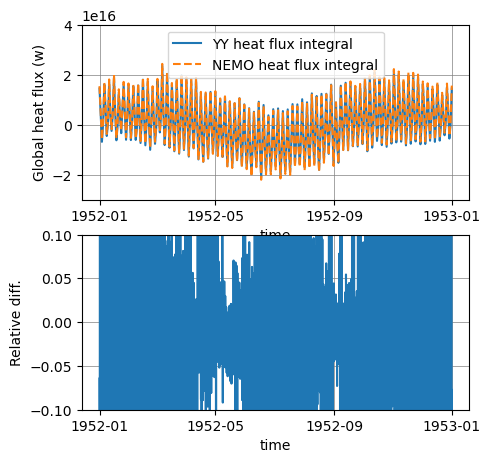

In [17]:
fig, (axt,axb) = plt.subplots(2,1,figsize=(5,5))

atm_net_heat[::10].plot(ax=axt, label='YY heat flux integral')
ocn_net_heat[::10].plot(ax=axt, linestyle='--', label='NEMO heat flux integral')
axt.legend()
axt.set_ylim([-3e16,4e16])
axt.set_ylabel('Global heat flux (w)')
axt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')

reldiff = ((atm_net_heat-ocn_net_heat) / (atm_net_heat+machine_epsilon))
reldiff.plot(ax=axb)
axb.set_ylim([-0.1,0.1])
axb.set_ylabel('Relative diff.')
axb.grid(which='major', linestyle='-', linewidth='0.5', color='gray')

print(reldiff.max().compute(),reldiff.mean().compute())

In [18]:
reldiff.mean().compute()

<xarray.DataArray ()>
array(0.05006038)

In [19]:
(atm_net_heat-ocn_net_heat).mean(dim='time').compute()

<xarray.DataArray ()>
array(-2.86360046e+14)

Text(0, 0.5, 'NEMO HF')

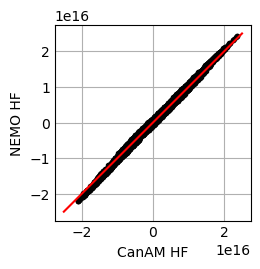

In [20]:
plt.style.use('_mpl-gallery')
plt.plot(atm_net_heat[5::], ocn_net_heat[5::], 'k.')
plt.plot([-2.5e16,2.5e16], [-2.5e16,2.5e16], 'r-')
plt.xlabel('CanAM HF')
plt.ylabel('NEMO HF')


(array([2.904e+03, 6.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([9.36056743e-06, 7.72000164e+00, 1.54399939e+01, 2.31599862e+01,
        3.08799785e+01, 3.85999708e+01, 4.63199631e+01, 5.40399553e+01,
        6.17599476e+01, 6.94799399e+01, 7.71999322e+01]),
 <BarContainer object of 10 artists>)

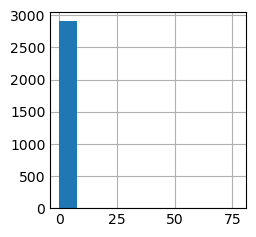

In [21]:
plt.hist(np.abs(reldiff+machine_epsilon))

In [22]:
atm_net_heat2 = (field_integral_yy(ds_cpl_his2.BEGI_atm_yin  * ds_cpl_his2.SICN_atm_yin, 
                                  ds_cpl_his2.BEGI_atm_yang * ds_cpl_his2.SICN_atm_yang ).persist() + 
                field_integral_yy(ds_cpl_his2.BEGO_atm_yin  * (1.0- ds_cpl_his2.SICN_atm_yin), 
                                  ds_cpl_his2.BEGO_atm_yang * (1.0- ds_cpl_his2.SICN_atm_yang)).persist())
ocn_net_heat2 = (field_integral_nemo(ds_cpl_his2.O_QnsMix).persist() + 
               field_integral_nemo(ds_cpl_his2.O_QsrMix).persist())

NameError: name 'ds_cpl_his2' is not defined

<xarray.DataArray ()>
array(1.58920557) <xarray.DataArray ()>
array(0.00048395)


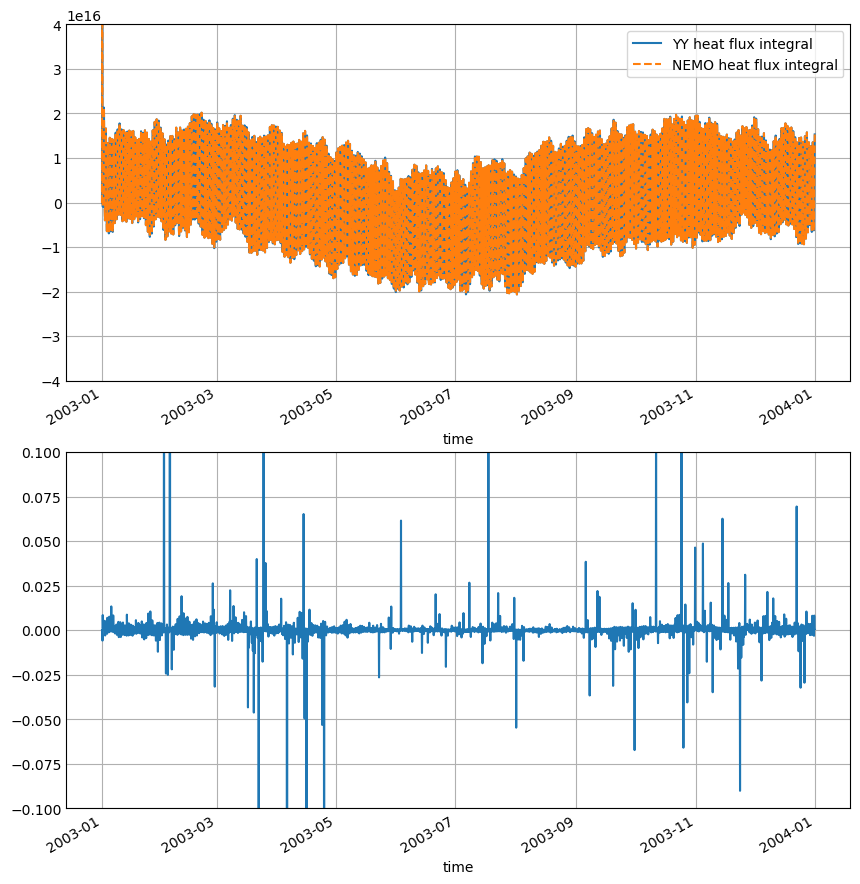

In [ ]:
fig, (axt,axb) = plt.subplots(2,1,figsize=(8,8))

atm_net_heat2.plot(ax=axt, label='YY heat flux integral')
ocn_net_heat2.plot(ax=axt, linestyle='--', label='NEMO heat flux integral')
axt.legend()
axt.set_ylim([-4e16,4e16])

reldiff2 = ((atm_net_heat2-ocn_net_heat2) / (atm_net_heat2+machine_epsilon))
reldiff2.plot(ax=axb)
axb.set_ylim([-0.1,0.1])
print(reldiff2.max().compute(),reldiff2.mean().compute())

In [ ]:
atm_ice_sw_heat = (field_integral_yy(ds_cpl_his1.FSGI_atm_yin, 
                                     ds_cpl_his1.FSGI_atm_yang).persist()
                )
ocn_ice_sw_heat = (field_integral_nemo(ds_cpl_his1.O_QsrIce).persist())

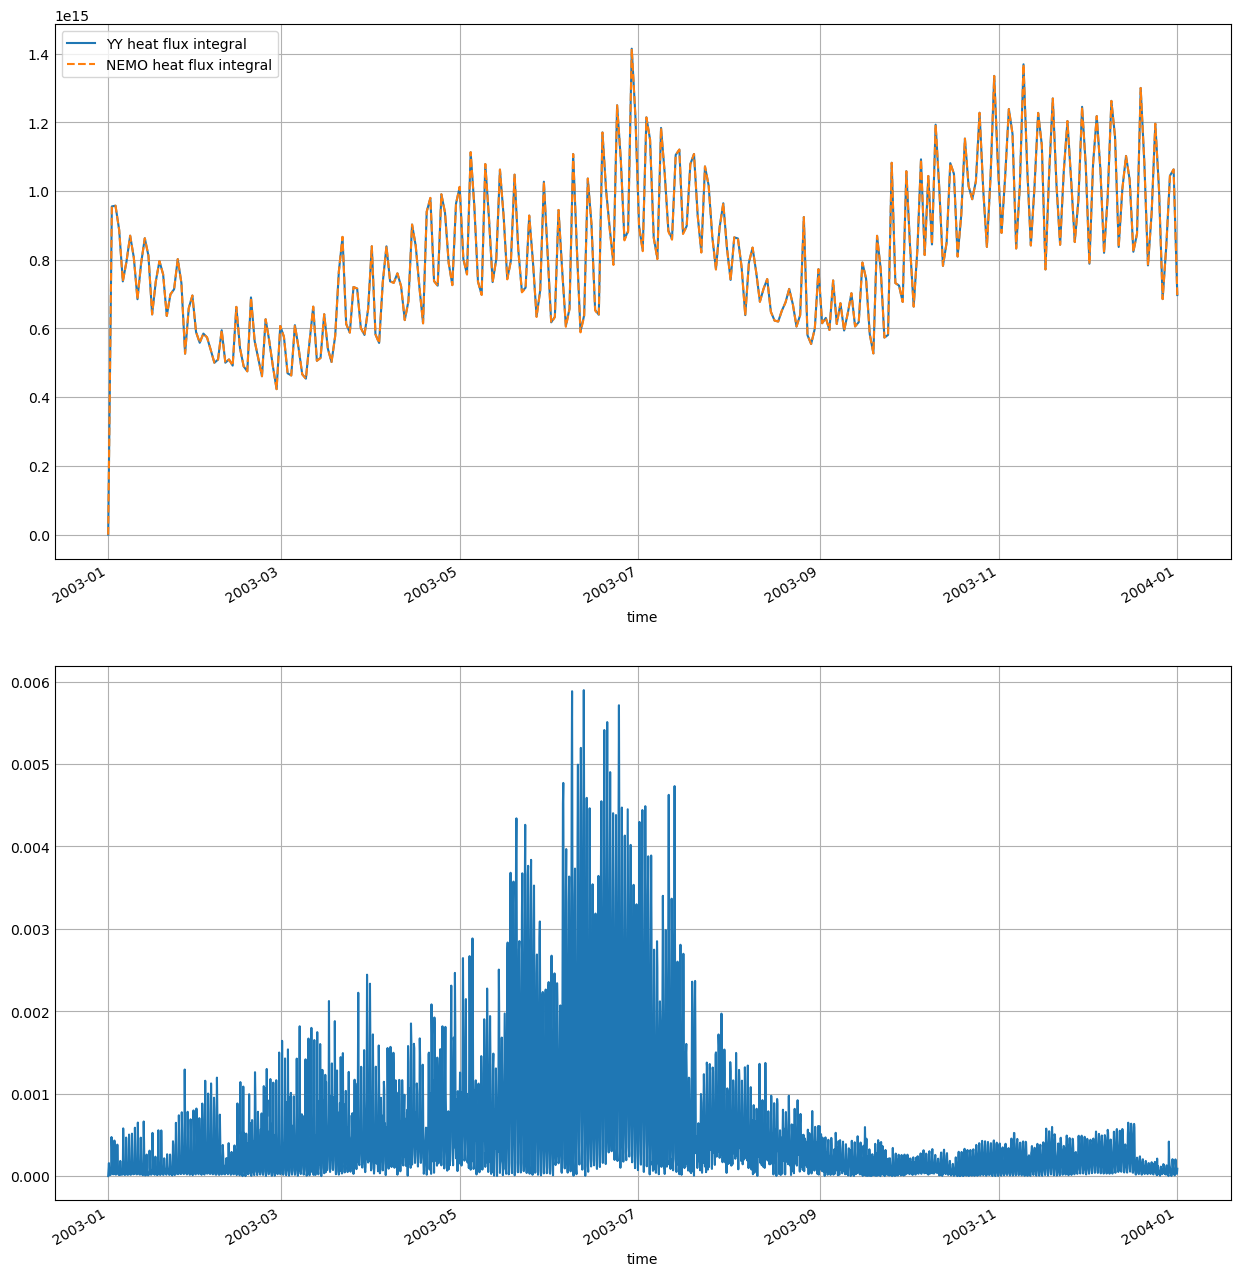

In [ ]:
fig, (axt,axb) = plt.subplots(2,1,figsize=(12,12))
atm_ice_sw_heat[::10].plot(ax=axt, label='YY heat flux integral')
ocn_ice_sw_heat[::10].plot(ax=axt, linestyle='--', label='NEMO heat flux integral')
axt.legend()

reldiff = (abs(ocn_ice_sw_heat - atm_ice_sw_heat)/(atm_ice_sw_heat+machine_epsilon))
reldiff[::1].plot(ax=axb)

In [ ]:
print(reldiff.max().compute(), reldiff.mean().compute())

<xarray.DataArray ()>
array(0.00589712) <xarray.DataArray ()>
array(0.00055202)


In [ ]:
atm_ice_sw_heat_uc = (field_integral_yy(ds_cpl_his2.FSGI_atm_yin, 
                                     ds_cpl_his2.FSGI_atm_yang).persist()
                )
ocn_ice_sw_heat_uc = (field_integral_nemo(ds_cpl_his2.O_QsrIce).persist())

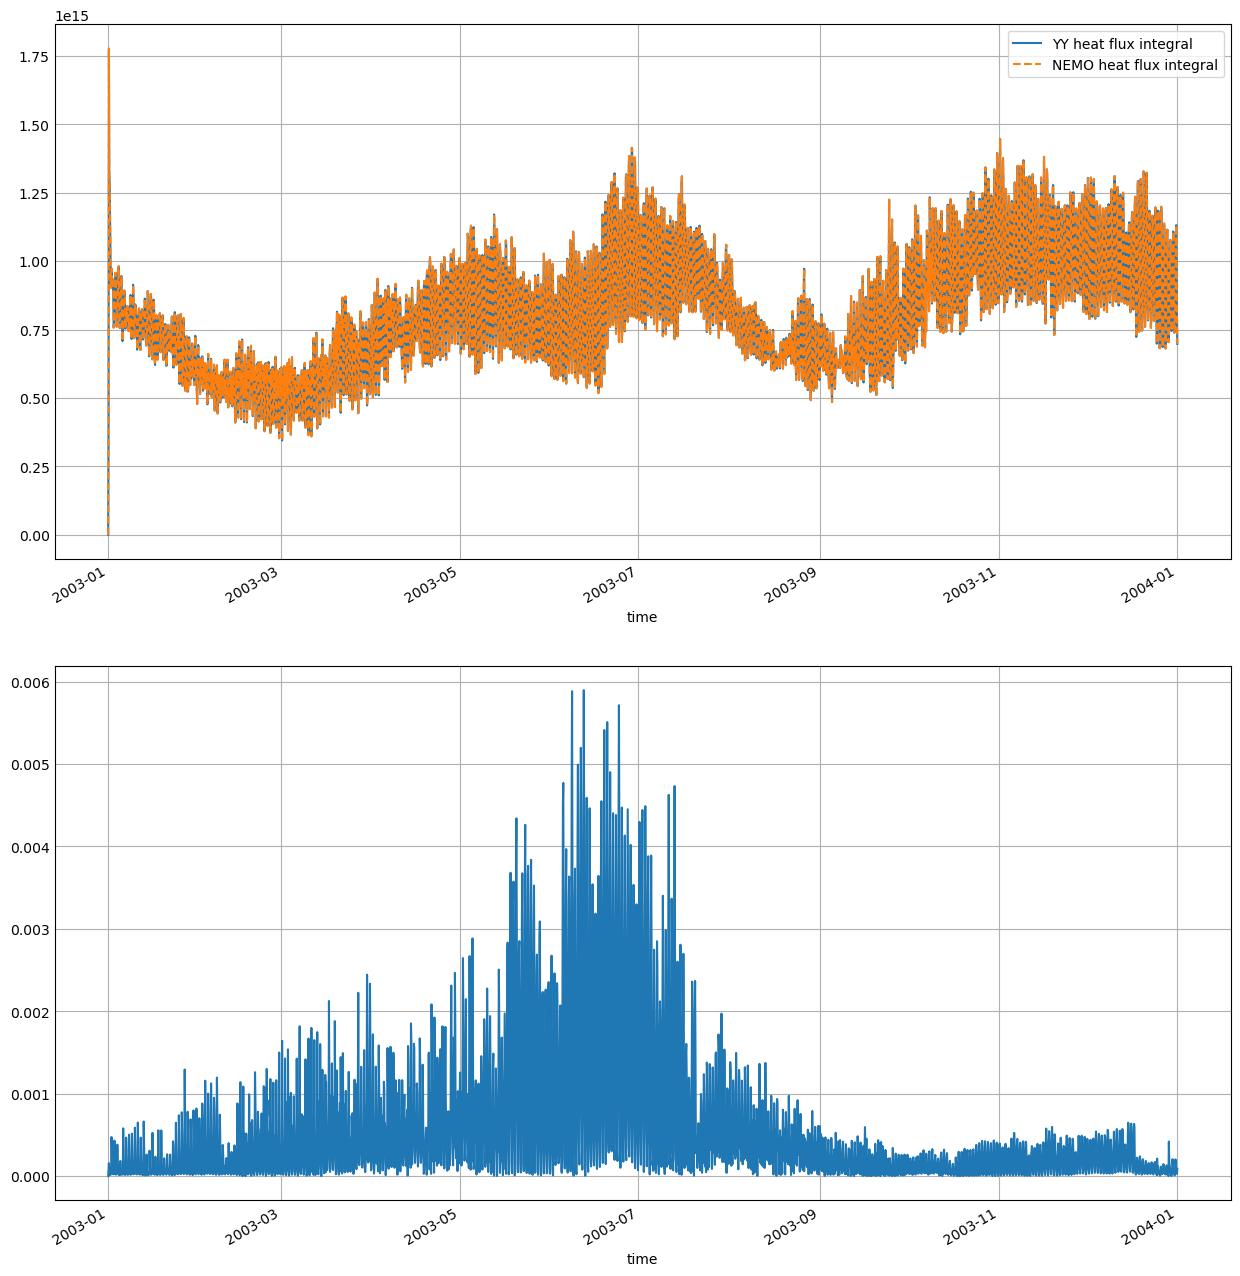

In [ ]:
fig, (axt,axb) = plt.subplots(2,1,figsize=(12,12))
atm_ice_sw_heat_uc.plot(ax=axt, label='YY heat flux integral')
ocn_ice_sw_heat_uc.plot(ax=axt, linestyle='--', label='NEMO heat flux integral')
axt.legend()

reldiff_uc = (abs(ocn_ice_sw_heat_uc - atm_ice_sw_heat_uc)/(atm_ice_sw_heat_uc+machine_epsilon))
reldiff_uc.plot(ax=axb)

In [ ]:
print(reldiff_uc.max().compute(), reldiff_uc.mean().compute())

<xarray.DataArray ()>
array(0.00589712) <xarray.DataArray ()>
array(0.00055202)


In [ ]:
ds_cpl_his1

<xarray.Dataset>
Dimensions:                                                       (time: 2921,
                                                                   nlat_atm_yin: 115,
                                                                   nlon_atm_yin: 303,
                                                                   nlat_atm_yang: 115,
                                                                   nlon_atm_yang: 303,
                                                                   nlat_ocn: 292,
                                                                   nlon_ocn: 362)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
Dimensions without coordinates: nlat_atm_yin, nlon_atm_yin, nlat_atm_yang,
                                nlon_atm_yang, nlat_ocn, nlon_ocn
Data variables: (12/109)
    lon_atm_yin                                                   (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lat_atm_yin                                                   (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lon_atm_yang                                                  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lat_atm_yang                                                  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    lon_ocn                                                       (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
    lat_ocn                                                       (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
    ...                                                            ...
    atm_yang2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_srcfrac  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    atm_yang2ocn_srcmaskF_dstmaskT_conserve_2nd_fracarea_dstfrac  (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
    atm_yin2ocn_srcmaskF_dstmaskT_conservative_fracarea_srcfrac   (nlat_atm_yin, nlon_atm_yin) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    atm_yin2ocn_srcmaskF_dstmaskT_conservative_fracarea_dstfrac   (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
    atm_yang2ocn_srcmaskF_dstmaskT_conservative_fracarea_srcfrac  (nlat_atm_yang, nlon_atm_yang) float64 dask.array<chunksize=(115, 303), meta=np.ndarray>
    atm_yang2ocn_srcmaskF_dstmaskT_conservative_fracarea_dstfrac  (nlat_ocn, nlon_ocn) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
Attributes:
    CCCma_runid:  default